# Imports and Pytorch Settings

In [1]:
# imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
from collections import defaultdict
from scipy.integrate import solve_ivp
from mpl_toolkits import mplot3d

In [2]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

# Check Library Version Info and GPU Availability

In [3]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Python VERSION:', sys.version)
  print('pyTorch VERSION:', torch.__version__)
  print('Active CUDA Device: GPU', torch.cuda.current_device())
  print('Available devices: ', torch.cuda.device_count())
  print('Current CUDA device: ', torch.cuda.current_device())
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()

Python VERSION: 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
pyTorch VERSION: 1.13.0+cu116
Active CUDA Device: GPU 0
Available devices:  1
Current CUDA device:  0
Thu Dec 15 06:29:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |      3MiB / 15109MiB |      4%      Default |
|                               |                      |                  N/A

# Compute Loss Function

In [4]:
# calculate du^n / dt^n for arbitrary n and use this to form loss
def compute_gradient(u, t, num_u_vectors):
    
    # compute gradient of outputs with respect to inputs 
    derivs_list = []
    for i in range(num_u_vectors):
        # individually compute du/dt for each u and combine them all together afterwards
        du_dt = torch.autograd.grad(u[:, i, :], t, grad_outputs=torch.ones_like(u[:, i, :]), create_graph=True)[0]
        derivs_list.append(du_dt)

    deriv_to_t = torch.stack(derivs_list, dim=1) 
    
    return deriv_to_t

# build the loss function
def loss(x, A_list, v_list, force, model):
    
    # dictionary to store loss results for plotting
    loss_dict = {} 
    # current loss
    L = 0
    
    # create the trial solution
    model_result = lambda x: model(x)[0]
    u_results = model_result(x)
   
    # determine the number of u vectors
    num_u_vectors = u_results['head 1'].shape[1]
    
    # loss will be the sum of the terms from the "multi-head" model, hence we iterate over each head's outputs
    for i, head_i in enumerate(u_results.keys()):
        # extract the u for the current "head", corresponding to one of the initial conditions
        u = u_results[head_i].unsqueeze(dim=-1)    
    
        # compute du/dx (Note: each u is computed separately to avoid torch.autograd.grad() summing them together)
        du_dx = compute_gradient(u, x, num_u_vectors)

        # extract du/dx1 and du/dx2
        du_dx1, du_dx2 = du_dx[:, :, 0:1], du_dx[:, :, 1:2]

        # compute A * du/x2
        A_times_du_dx2 = torch.matmul(A_list[i], du_dx2)
    
        # compute the L_T term
        L_t_term = du_dx1 + A_times_du_dx2 - torch.stack([force] * len(x)) 
        L_t = torch.matmul(L_t_term.mT, L_t_term)
        
        # compute the L_0_1 term (boundary condition)
        x1, x2 = x[:, 0:1], x[:, 1:2]
        u_0_1 = model_result(torch.cat([x1, x1], dim=1))[head_i] # TODO: hard-coded model_result(x1, x1), but no other way here?
        L_0_1_term = u_0_1 - torch.sin(x1.squeeze()).reshape(-1, num_u_vectors) # TODO: take in boundary condition in v_list and don't hardcode sin here
        L_0_1 = torch.matmul(L_0_1_term.T, L_0_1_term)
        # WARNING: the x1.squeeze() inside torch.sine() above might fail for multiple PDEs, revisit this...

        # compute the overall loss 
        L += (torch.mean(L_t) + torch.mean(L_0_1))
    
    loss_dict['L_D'] = L
    loss_dict['L_total'] = L

    return loss_dict

# Build Network

In [5]:
# class to build the network 
class BuildNetwork(nn.Module):
    def __init__(self, input_size, h_size1, h_size2, h_size3, output_size, n_heads):
        super(BuildNetwork, self).__init__()
        # store the number of "heads" to use in the model
        self.n_heads = n_heads
        
        # build the layers to use for the forward pass
        self.l1 = nn.Linear(input_size, h_size1)
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(h_size1, h_size2)
        self.l3 = nn.Linear(h_size2, h_size3)
        
        # build n_heads output layers, each corresponding to different conditions during training
        self.multi_head_output = nn.ModuleList([nn.Linear(h_size3, output_size)])
        self.multi_head_output.extend([nn.Linear(h_size3, output_size) for i in range(n_heads-1)])
         
    def forward(self, x):
        # dictionary to store the output for each "head" in the model
        u_results = {}
        
        # all "heads" have the same pass through the hidden laers
        result = self.l1(x)
        result = self.tanh(result)
        result = self.l2(result)
        result = self.tanh(result)
        result = self.l3(result)
        h = self.tanh(result)
        
        # apply the corresponding output layer to each "head"
        for i in range(self.n_heads):
            result_i = self.multi_head_output[i](h)
            u_results[f"head {i + 1}"] = result_i
            
        return u_results, h

# Train Model

In [6]:
# train and evaluate the model
def run_model(iterations, x_range, num_inputs, A_list, v_list, force, hid_lay, 
              num_equations, num_heads, true_functs, head_to_track):
        
    assert num_equations > 0, 'num_equations must be >= 1'
    assert len(v_list) == num_heads, 'num_heads must equal the length of v_list'
    assert len(A_list) == num_heads, 'num_heads must equal the length of A_list'
    assert len(v_list[0]) == num_equations, 'num_equations does not match equation set-up'
    assert len(A_list[0]) == num_equations, 'num_equations does not match equation set-up'
    assert hid_lay[-1] % num_equations == 0, 'last hidden layer does not evenly divide num_equations for transfer learning'
    
    # build the neural net model
    model = BuildNetwork(num_inputs, hid_lay[0], hid_lay[1], hid_lay[2], num_equations, num_heads).to(dev)    
    # set-up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # create a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    # extract the min and max range of values to sample
    min_x, max_x = x_range
    
    # index of the head being tracked for MSE
    head_idx = int(head_to_track.split()[-1]) - 1
    
    # create a random number generator for loss computation
    rng = np.random.default_rng()
    
    # store loss and mse values
    loss_history = defaultdict(list)
    MSEs = []
    
    start_time = time.time()
    
    # training loop
    for i in range(iterations):
        
        if i % 1000 == 0:
            print(f"Running Iteration {i + 1}")
        
        # every batch, randomly sample inputs from min and max range
        data = torch.arange(min_x, max_x, 0.001, requires_grad=True, device=dev)
    
        # generate x1 and x2 separately to create 2D PDE input
        x1 = data[rng.choice(range(0, len(data)), size=50, replace=False)]
        x1, _ = x1.reshape(-1, 1).sort(dim=0)
        x2 = data[rng.choice(range(0, len(data)), size=50, replace=False)]
        x2, _ = x2.reshape(-1, 1).sort(dim=0)
        x = torch.cat([x1, x2], dim=1)

        # forward: compute loss
        curr_loss = loss(x, A_list, v_list, force, model)
        
        # store individual loss terms for plotting
        loss_history['LD_losses'].append(curr_loss['L_D'].detach().item())
        loss_history['Ltotal_losses'].append(curr_loss['L_total'].detach().item())
            
        # backward: backpropagation
        curr_loss['L_total'].backward()
        
        # update weights and reset the gradients
        optimizer.step() 
        optimizer.zero_grad() 
        
        # learning rate update
        # scheduler.step()
        
        # compute the mse for the head that is being monitored ('head_to_track')
        with torch.no_grad():
            current_mse = 0
            for j in range(num_equations):
                network_sol_j = model(x)[0][head_to_track][:, j].cpu().unsqueeze(dim=1).numpy()
                true_sol_j = true_functs(x1.cpu(), x2.cpu(), A_list[head_idx].cpu())[j]
                true_sol_j = np.expand_dims(true_sol_j, axis=1)
                current_mse += np.mean((true_sol_j - network_sol_j) ** 2)
            MSEs.append(current_mse)
               
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Model Training Complete in{total_time: .3f} seconds")
    
    return loss_history, model, total_time, MSEs

# Plot Solution, Loss, and MSE Information

In [7]:
# function to plot the neural network vs exact solution
def plot_solution(x_range, true_functs, trained_model, v_list, A_list, force, axis, head_to_track):
    
    # function to extract the model results
    model_result = lambda t: trained_model(t)[0]
    
    # x values to predict on
    min_x, max_x = x_range
    xx1 = np.linspace(min_x, max_x, 200)[:, None]
    xx2 = np.linspace(min_x, max_x, 200)[:, None]

    # find the model results
    u = model_result(torch.tensor(np.concatenate((xx1, xx2), axis=1), 
                                  dtype=torch.float32, device=dev))[head_to_track] 

    # determine the number of curves to plot
    num_curves = u.shape[1]
    # store the true solutions and network solutions
    yys, yts = [], []

    # save the network solutions in a list for plotting 
    with torch.no_grad():
        head_idx = int(head_to_track.split()[-1]) - 1
        for i in range(num_curves):
            yys.append(u[:, i].cpu().numpy())
            yts.append(true_functs(torch.tensor(xx1, dtype=torch.float32),
                                   torch.tensor(xx2, dtype=torch.float32), A_list[head_idx].cpu()))
                    
    # plot the network solutions
    for i in range(num_curves):
      axis.plot3D(xx1, xx2, yys[i], 'x', 
                  label=f'Network Solution $u_{{{i+1}}}(x_1, x_2)$ ({head_to_track})', 
                  linewidth=3.5)

    # plot the true solutions
    for i in range(num_curves):
      axis.plot3D(xx1, xx2, yts[0].squeeze(), label=f'Actual Solution $u_{{{i+1}}}(x_1, x_2)$', 
                  linewidth=2.5)

    axis.set_title("Actual vs Approximation Solutions")
    axis.set_xlabel('$x_1$')
    axis.set_ylabel('$x_2$')
    axis.set_zlabel('$u(x_1, x_2)$')
    axis.legend(loc='lower right')
    
# function to plot the overall loss of the network solution
def plot_total_loss(iterations, train_losses, axis, loss_label):
    axis.plot(range(iterations), train_losses, label=loss_label)
    axis.set_yscale("log")
    axis.set_title("Total Loss vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('Loss')
    axis.legend(loc='best')
    
# function to plot the MSEs
def plot_mse(iterations, mses, axis, head_to_track):
    axis.plot(range(iterations), mses, label=f'MSE ({head_to_track})')
    axis.set_yscale("log")
    axis.set_title("MSE vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('MSE')
    axis.legend(loc='best')
    
# wrapper function to plot the solution and the overall loss & MSE of the network solution
def plot_loss_mse_and_solution(x_range, true_functs, iterations, trained_model, v_list, 
                               A_list, force, train_losses, loss_label, mses, head_to_track):
    
    fig = plt.figure(figsize=(24, 8))
    
    ax_0 = fig.add_subplot(1, 3, 1)
    plot_total_loss(iterations=iterations, train_losses=train_losses, 
                    axis=ax_0, loss_label=loss_label)
    
    ax_1 = fig.add_subplot(1, 3, 2, projection='3d')
    plot_solution(x_range=x_range, true_functs=true_functs, 
                  trained_model=trained_model, v_list=v_list,
                  A_list=A_list, force=force, axis=ax_1, 
                  head_to_track=head_to_track)
    
    ax_2 = fig.add_subplot(1, 3, 3)
    plot_mse(iterations=iterations, mses=mses, axis=ax_2, 
             head_to_track=head_to_track)
    
    plt.show()

# Find Output Layer Weights with Transfer Learning

In [8]:
def compute_H_and_dH_dt(min_x, max_x, trained_model, num_equations, hid_lay):
    
    start_time = time.time()
    
    # generate a set of times to evaluate with
    rng = np.random.default_rng()
    t_eval = torch.arange(min_x, max_x, 0.001, requires_grad=True, device=dev)
    t_eval = t_eval[rng.choice(range(0, len(t_eval)), size=500, replace=False)]
    t_eval = t_eval.reshape(-1, 1)
    t_eval, _ = t_eval.sort(dim=0)
        
    # forward pass with t_eval to extract H 
    _, H = trained_model(t_eval)
    # reshape "H" to batch_size X num_equations X d // num_equations
    H = H.reshape(-1, num_equations, hid_lay[-1] // num_equations)
    H = torch.cat((torch.ones(len(t_eval), num_equations, 1, device=dev), H), 2)
    
    # forward pass with t = 0 to extract H_0
    _, H_0 = trained_model(torch.tensor([[0.]], dtype=torch.float32, 
                                        requires_grad=True, device=dev))
    # reshape "H_0" to batch_size X num_equations X d // num_equations
    H_0 = H_0.reshape(-1, num_equations, hid_lay[-1] // num_equations)
    H_0 = torch.cat((torch.ones(1, num_equations, 1, device=dev), H_0), 2).squeeze()
    H_0 = H_0.unsqueeze(dim=0) if num_equations == 1 else H_0

    # compute dH_dt 
    _, H_orig = trained_model(t_eval)
    dH_dt =[torch.autograd.grad(H_orig[:, i], t_eval, grad_outputs=torch.ones_like(H_orig[:, i]), create_graph=True)[0] for i in range(H_orig.shape[1])]
    dH_dt = torch.hstack(dH_dt)
    dH_dt_new = dH_dt.reshape(-1, num_equations, hid_lay[-1] // num_equations)
    dH_dt_new = torch.cat((torch.zeros(len(t_eval), num_equations, 1, device=dev), dH_dt_new), 2)

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Time to compute H and dH_dt: {total_time: .3f} seconds")

    return H, H_0, dH_dt_new, t_eval

In [9]:
def analytically_compute_weights(dH_dt, H, H_0, t_eval, v, A, force):
    
    start_time = time.time()
    
    # compute dH_dt * dH_dt.T
    dH_dt_times_dH_dt_T = torch.matmul(dH_dt.mT, dH_dt)

    # compute dH_dt * A * H
    dH_dt_times_A_times_H = torch.matmul(torch.matmul(dH_dt.mT, A), H)

    # compute H.T * A.T * dH_dt
    H_times_A_T_times_dH_dt = torch.matmul(torch.matmul(H.mT, A.T), dH_dt)

    # compute H.T * A.T * A * H
    H_T_times_A_T_times_A_times_H = torch.matmul(torch.matmul(torch.matmul(H.mT, A.T), A), H)
    
    # compute the "summation portion" of the M matrix 
    M_sum_terms = dH_dt_times_dH_dt_T + dH_dt_times_A_times_H + H_times_A_T_times_dH_dt + H_T_times_A_T_times_A_times_H
    M_sum_terms = M_sum_terms.sum(axis=0)
    M_sum_terms = M_sum_terms / len(t_eval)

    # compute H_0.T * H_0
    H_0_T_times_H_0 = torch.matmul(H_0.mT, H_0)
    
    # compute the "M" matrix and invert it
    M = M_sum_terms + H_0_T_times_H_0
    M_inv = torch.linalg.pinv(M)
    
    # compute dH_dt * force
    dH_dt_times_force = torch.matmul(dH_dt.mT, force)
    
    # compute H * A.T * force
    dH_dt_times_A_T_times_f = torch.matmul(torch.matmul(H.mT, A.T), force) # TODO: FIX variable name since it should be H_times_A_T_times_f
    
    # sum the force-contributing terms and add them to H_0.T * v
    force_terms = dH_dt_times_force + dH_dt_times_A_T_times_f
    force_terms = force_terms.sum(axis=0)
    force_terms = force_terms / len(t_eval)
    rhs_terms = force_terms + torch.matmul(H_0.T, v)

    # compute the output weights by W_out = M ^ -1 * H_0 * u_0
    W_out = torch.matmul(M_inv, rhs_terms)
    
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Time to compute weights (given H and dH_dt): {total_time: .3f} seconds")

    return M_inv, W_out, force_terms

# Plot Transfer Learned and Analytical Solutions

In [10]:
def plot_transfer_learned_and_analytical(H, W_out, t_eval, v, A, force, num_equations, true_funct):
    
    # compute the transfer learned solution
    u_transfer = torch.matmul(H, W_out)

    # plot the transfer learned solutions
    for i in range(num_equations):
        plt.plot(t_eval.detach().cpu().numpy(), u_transfer[:, i, :].detach().cpu().numpy(), 'x',
                    label=f'Transfer Learned $U_{{{i+1}}}$', linewidth=3.5);

    # plot the true solutions
    for i in range(num_equations):
        plt.plot(t_eval.detach().cpu().numpy(), 
                    true_funct(t_eval.detach().cpu().numpy(), v.detach().cpu(), A.detach().cpu(), force.detach().cpu())[i], 
                    label= f'True $U_{{{i+1}}}$', linewidth=2.5);
    
    plt.xlabel("t")
    plt.ylabel("$u(t)$")
    plt.title("Transfer Learned vs Analytical Solution")
    plt.legend();

# Execute

### Step 1: Choose Network Parameters and Set-up Differential Equations

In [11]:
# set-up network training parameters
x_range = [0, 2]
hid_lay = [128, 128, 128]
num_inputs = 2
num_equations = 1
iterations = 15000

# set-up initial conditions for various differential equations
v_list_one_eq = [torch.tensor([[0.12]], device=dev), 
                 torch.tensor([[0.87]], device=dev), 
                 torch.tensor([[0.34]], device=dev), 
                 torch.tensor([[0.75]], device=dev)]
# v_list_one_eq_pde = 0 # TODO: need to figure out a way to pass in BV condition, perhaps use list of lambda functions
                    
# set-up forcing function
force_one_eq_pde = torch.tensor([[0.]], device=dev)

# set up A matrix for various differential equations
A_single_eq_pde = [torch.tensor([[-1.]], device=dev), 
               torch.tensor([[-1.]], device=dev), 
               torch.tensor([[-1.]], device=dev), 
               torch.tensor([[-1.]], device=dev)]  

In [12]:
# analytical solutions for various partial differential equations

def single_pde_eq(x, t, A):
  return np.array(torch.sin((x - A[0][0] * t) / (1 - A[0][0]))).reshape(-1, len(x)) # for A = -1.0, should be sin((x + t) / 2)

true_single_pde_eq = lambda x, t, A: single_pde_eq(x, t, A)

### Step 2: Run Model

In [13]:
# choose the equation(s) to work with
A_list = A_single_eq_pde
true_funct = true_single_pde_eq
v_list = v_list_one_eq
force = force_one_eq_pde
num_heads = 4
head_to_track = 'head 1'

# run model which has two non-coupled equations
loss_hist, trained_model, model_time, MSE_hist = run_model(iterations=iterations, x_range=x_range, 
                                                           num_inputs=num_inputs, A_list=A_list, 
                                                           v_list=v_list, force=force,
                                                           hid_lay=hid_lay, num_equations=num_equations, 
                                                           num_heads=num_heads, true_functs=true_funct,
                                                           head_to_track=head_to_track)

Running Iteration 1
Running Iteration 1001
Running Iteration 2001
Running Iteration 3001
Running Iteration 4001
Running Iteration 5001
Running Iteration 6001
Running Iteration 7001
Running Iteration 8001
Running Iteration 9001
Running Iteration 10001
Running Iteration 11001
Running Iteration 12001
Running Iteration 13001
Running Iteration 14001
Model Training Complete in 186.352 seconds


### Step 3: View Training Results and History

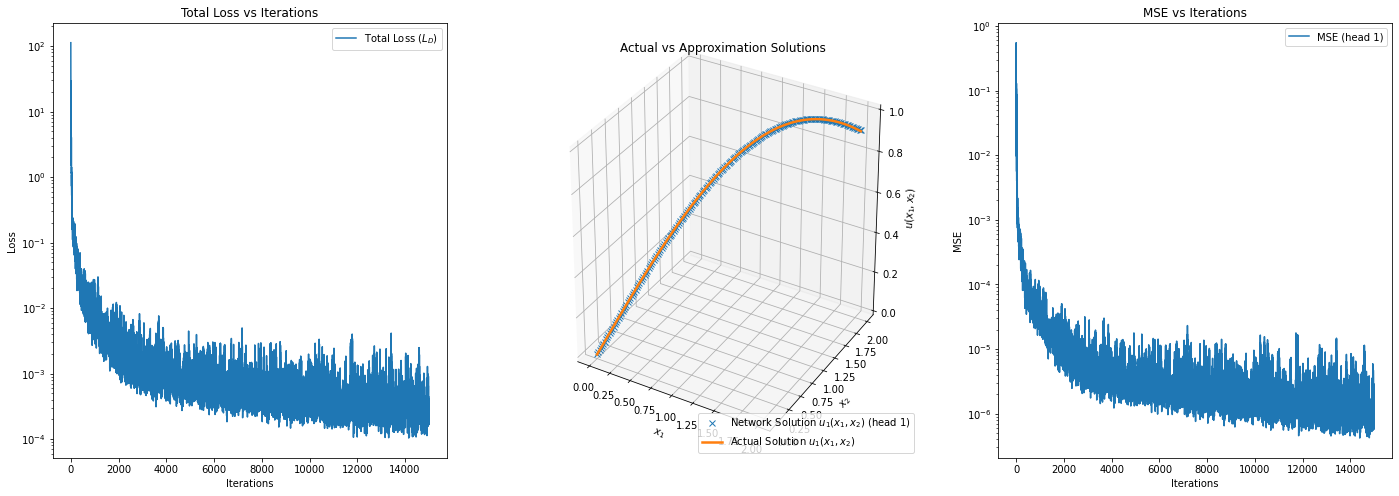

In [14]:
# plot the total loss, network vs true solution and MSE for two non-coupled equations
plot_loss_mse_and_solution(x_range=x_range, true_functs=true_funct, iterations=iterations, 
                           trained_model=trained_model, v_list=v_list, A_list=A_list, 
                           force=force, train_losses=loss_hist['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D$)', mses=MSE_hist, 
                           head_to_track=head_to_track)

### Step 4a: Perform One-Shot Transfer Learning (use an initial condition that was trained on)

Time to compute H and dH_dt:  0.109 seconds
Time to compute weights (given H and dH_dt):  1.222 seconds


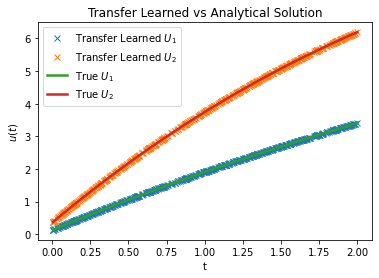

In [ ]:
H, H_0, dH_dt_new, t_eval = compute_H_and_dH_dt(x_range[0], x_range[1], trained_model, num_equations, hid_lay)

# pick an initial condition and matrix from those that were trained on (easy case)
v = v_list[0]
A = A_list[0]
M_inv, W_out, force_terms = analytically_compute_weights(dH_dt_new, H, H_0, t_eval, 
                                                         v, A, force)
plot_transfer_learned_and_analytical(H, W_out, t_eval, v, A, force, 
                                     num_equations, true_funct)

### Step 4b: Perform One-Shot Transfer Learning (use a new, unseen initial condition)

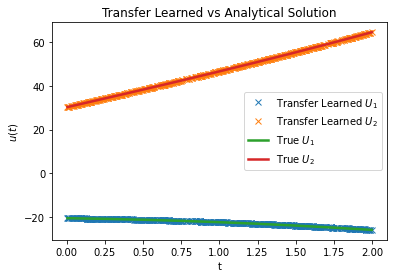

In [ ]:
# choose new initial condition that has not been trained on (harder case)
v_transfer = torch.tensor([[-20.69], [30.25]], device=dev)
# compute the transfer learned solution
W_out_transfer = torch.matmul(M_inv, force_terms + torch.matmul(H_0.T, v_transfer))
plot_transfer_learned_and_analytical(H, W_out_transfer, t_eval, v_transfer, A, force, 
                                     num_equations, true_funct)

### Step 4c: Perform One-Shot Transfer Learning (use a new diff eq. and an initial condition that was trained on)

Time to compute weights (given H and dH_dt):  0.007 seconds


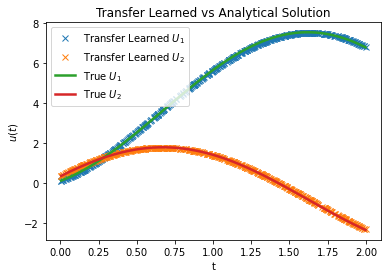

In [ ]:
# new differential equation to apply training to
transfer_A = torch.tensor([[0, -2.5], [1.1, 0]], device=dev)

M_inv_new, W_out_new_A, force_terms_new = analytically_compute_weights(dH_dt_new, H, H_0, t_eval, 
                                                                       v, transfer_A, force)
plot_transfer_learned_and_analytical(H, W_out_new_A, t_eval, v, transfer_A, force, 
                                     num_equations, true_funct)

### Step 4d: Perform One-Shot Transfer Learning (use a new diff eq. and an unseen initial condition)

Time to compute weights (given H and dH_dt):  0.007 seconds


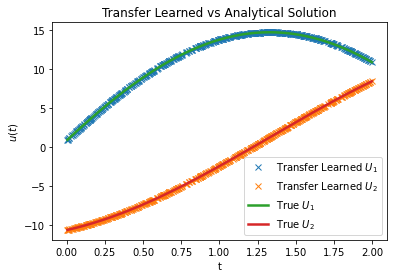

In [ ]:
# create a step d markdown where both initial condition and differential equation are changed
transfer_A = torch.tensor([[0, 1.55], [-0.5, 0]], device=dev)
v_transfer_new = torch.tensor([[-0.87], [0.62]], device=dev)

M_inv_new_all, W_out_new_A_all, force_terms_new_all = analytically_compute_weights(dH_dt_new, H, H_0, t_eval, 
                                                                           v_transfer_new, transfer_A, force)
plot_transfer_learned_and_analytical(H, W_out_new_A_all, t_eval, v_transfer_new, transfer_A, 
                                     force, num_equations, true_funct)


# Appendix

Mean of residuals: 0.0007473001023754478
Initial Condition Residual: 1.7308775568380952e-07


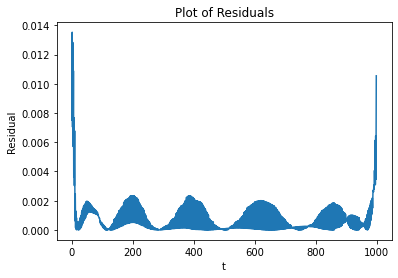

In [ ]:
# compute the residuals to determine effectiveness of transfer learning when changing initial condition
residuals = ((torch.matmul(dH_dt_new, W_out_transfer) + torch.matmul(A, torch.matmul(H, W_out_transfer)) - torch.stack([force] * len(t_eval))).squeeze()) ** 2
residuals = residuals.reshape(-1, 1).detach().cpu().numpy()

print(f"Mean of residuals: {residuals.mean()}")
initial_cond_residuals = ((torch.matmul(H_0, W_out_transfer) - v_transfer) ** 2).mean()
print(f"Initial Condition Residual: {initial_cond_residuals.item()}")

# plot the residuals
plt.plot(residuals);
plt.xlabel("t")
plt.ylabel("Residual")
plt.title("Plot of Residuals");

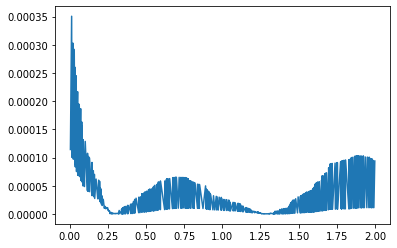

In [ ]:
plt.plot(t_eval.detach().cpu().numpy(), residuals[0:500])

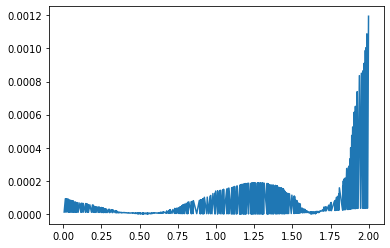

In [ ]:
plt.plot(t_eval.detach().cpu().numpy(), residuals[500:])

In [ ]:
# time One-Shot Transfer Learning

start_one_shot_time = time.time()

# compute weights for 10000 different initial conditions
for i in range(10000): 
    random_u_0 = torch.rand((num_equations, 1), device=dev)
    w_out = torch.matmul(M_inv, force_terms + torch.matmul(H_0.T, random_u_0))
    
end_one_shot_time = time.time() 
total_one_shot = end_one_shot_time - start_one_shot_time
print(f"Total Time to evaluate w_out for 10000 different initial conditions: {total_one_shot: .2f} seconds")

Total Time to evaluate w_out for 10000 different initial conditions:  0.55 seconds


In [ ]:
# QUESTIONS:

# TODOS:


# 0. Make notes in notebook from meeting with Pavlos about how to handle BX + AY = f equation - seems to be all set 

# 1. add in docstrings for all functions

# 2. try and further improve training on gpu for pytorch 
    
# 3. guranteee a 0 point in each iteration of the loss 

# 4. create a config file for all the configuration info...

# 5. latex the forcing term equation from whiteboard

# 6. Implement MSE so that MSES for all heads are stored and can
#  be accessed when changing the head being plotted

# 7. Ask Pavlos / figure out why the [0, 4] range does not work well for two higher order PDEs: "true_double_higher_order_eq"

########################################################################################################################

# 1. go through all code and verify shapes, especially in Loss function

# 2. try higher order ODE with formulation which Pavlos showed...

# 5. TEST: see if transfer learning with new A works if in training we don't change A at all - DONE

# 3. TEST: try running the A_coupled_2_eq_easy to see how it performs on different heads - DONE

# 2. TEST: try running coupled equations with no forcing to see if the residuals look normal - DONE

# 4. TEST: run the A_coupled_2_eq_hard with no forcing function to see if it matches .v2 code results - DONE

# 6. try tracking a different head (other than head 1, to see if any errors) - DONE

# 3. fix residual code in appendix - DONE

# 1. TODO: rename to true_coupled_2_eq and create double_non_coupled_equation and triped_coupled_equation - DONE

# 2. fix timing code in appendix - DONE

# 3. put in an assert before training so that the reshape with H will work out - DONE

# 4. check initial condition difference between wolfram alpha and sympy - DONE

# 5. code-up the new version of the equation with forcing function -DONE

# 6. remove jacobian call with something else -DONE

# 7. the true/analytical functions need to take in an "A" parameter so we can customize the plotting...
    # need to use scipy library solve_ivp (or autodiff library and convert to lambda function) -DONE

# 8. write out math in notebook from Pythia and label it according to the right meeting week - DONE

# 9. write-out multi-headed approach in notebook - DONE

# 10. do github organize / update - DONE

# 11. modularize all code - DONE

# 12. try 3 coupled equations - DONE

# 13. time the one-shot transfer learning with different A - DONE

# 14. modularize all code including transfer learning so that it is part of main computation function, just in a conditional - DONE

# 15. delete all the normalization code from loss, including the "norm_term" parameter - DONE

In [ ]:
# analytical solutions for various differential equations
# true_single_eq = [lambda x, v: (force_one_eq[0] / 1.05 + v[0] * np.exp(-1.05 * x)).numpy()]

# true_non_coupled_2_eq_easy = [lambda x, v: (v[0] * np.exp(-1.1 * x)).numpy(), 
#                               lambda x, v: (v[1] * np.exp(-1.1 * x)).numpy()]

# true_non_coupled_2_eq_hard = [lambda x, v: (v[0] * np.exp(-1.1 * x)).numpy(), 
#                               lambda x, v: (v[1] * np.exp(-3 * x)).numpy()]

# true_coupled_2_eq_easy = [lambda x, v: (0.5 * v[0] * np.exp(-1.1 * x) * (np.exp(2.2 * x) + 1) - (0.5 * v[1] * np.exp(-1.1 * x) * (np.exp(2.2 * x) - 1))).numpy(),
#                          lambda x, v: (0.5 * v[1] * np.exp(-1.1 * x) * (np.exp(2.2 * x) + 1) - (0.5 * v[0] * np.exp(-1.1 * x) * (np.exp(2.2 * x) - 1))).numpy()]

# true_coupled_2_eq_hard = [lambda x, v: (0.5 * v[0] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) + 1) - (0.428174 * v[1] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) - 1))).numpy(),
#                           lambda x, v: (0.5 * v[1] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) + 1) - (0.583874 * v[0] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) - 1))).numpy()]

# true_coupled_3_eq = [lambda x, v : (1/3 * v[0] * np.exp(-2 * x) * (2 * np.exp(3 * x) * np.cos(np.sqrt(3) * x) + 1) - 1/3 * v[1] * np.exp(-2 * x) * (np.exp(3 * x) * (np.cos(np.sqrt(3) * x) - np.sqrt(3) * np.sin(np.sqrt(3) * x)) - 1) - 1/3 * v[2] * np.exp(-2 * x) * (np.exp(3 * x) * (np.cos(np.sqrt(3) * x) + np.sqrt(3) * np.sin(np.sqrt(3) * x)) - 1)).numpy(), 
#                      lambda x, v : (1/3 * v[1] * np.exp(-2 * x) * (2 * np.exp(3 * x) * np.cos(np.sqrt(3) * x) + 1) - 1/3 * v[0] * np.exp(-2 * x) * (np.exp(3 * x) * (np.cos(np.sqrt(3) * x) + np.sqrt(3) * np.sin(np.sqrt(3) * x)) - 1) - 1/3 * v[2] * np.exp(-2 * x) * (np.exp(3 * x) * (np.cos(np.sqrt(3) * x) - np.sqrt(3) * np.sin(np.sqrt(3) * x)) - 1)).numpy(), 
#                      lambda x, v : (1/3 * v[2] * np.exp(-2 * x) * (2 * np.exp(3 * x) * np.cos(np.sqrt(3) * x) + 1) - 1/3 * v[0] * np.exp(-2 * x) * (np.exp(3 * x) * (np.cos(np.sqrt(3) * x) - np.sqrt(3) * np.sin(np.sqrt(3) * x)) - 1) - 1/3 * v[1] * np.exp(-2 * x) * (np.exp(3 * x) * (np.cos(np.sqrt(3) * x) + np.sqrt(3) * np.sin(np.sqrt(3) * x)) - 1)).numpy()]
